In [6]:
import torch
import torch.nn as nn


class SimpleUNetV2(nn.Module):
    def __init__(self, dropout_rate: float = 0.3) -> None:
        super().__init__()
        self.dropout_rate = dropout_rate

        # Encoder
        self.enc1 = self.conv_block(4, 32)
        self.enc2 = self.conv_block(32, 64)

        # Bottleneck
        self.bottleneck = self.conv_block(64, 128)
        self.dropout_bottleneck = nn.Dropout2d(p=self.dropout_rate)

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.dropout_dec1 = nn.Dropout2d(p=self.dropout_rate)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64, 32)

        self.final = nn.Conv2d(32, 1, kernel_size=1)
        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_ch: int, out_ch: int) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: nn.Sequential) -> nn.Conv2d:
        # Encode
        x1 = self.enc1(x)  # (B, 32, H, W)
        x2 = self.enc2(self.pool(x1))  # (B, 64, H/2, W/2)

        # Bottleneck + dropout
        x3 = self.bottleneck(self.pool(x2))
        x3 = self.dropout_bottleneck(x3)  # (B, 128, H/4, W/4)

        # Decode
        x4 = self.up1(x3)
        x4 = self.dec1(torch.cat([x4, x2], dim=1))
        x4 = self.dropout_dec1(x4)

        x5 = self.up2(x4)
        x5 = self.dec2(torch.cat([x5, x1], dim=1))

        return self.final(x5)  # (B, 1, H, W)


In [ ]:
import numpy as np
import pandas as pd
import rasterio
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset


class InferenceSegmentationDataset(Dataset):
    def __init__(self, csv_file: Path) -> None:
        self.data = pd.read_csv(csv_file)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> torch.Tensor:
        row = self.data.iloc[idx]

        channels = []
        for band in ["red", "green", "blue", "near_infrared"]:
            with rasterio.open(row[band]) as src:
                img = src.read(1).astype(np.float32) / 65535.0  # 2D image
                channels.append(img)

        image = np.stack(channels, axis=0)  # (4, H, W)

        return torch.tensor(image, dtype=torch.float32)


dataset = InferenceSegmentationDataset(
    Path("dataset.csv"),
)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
for images in loader:
    print(images.shape)  # Should be (batch_size, 4, H, W)
    break  # Just to test the first batch

ValueError: too many values to unpack (expected 2)

In [7]:
model = SimpleUNetV2()
# load model on cpu
model.load_state_dict(
    torch.load(
        Path(
            r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\satellite\exploration\models\simple_unet_v2_subset4000_epoch20.pth"
        ),
        map_location=torch.device("cpu"),
    )
)

<All keys matched successfully>

---

In [12]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torch
import rasterio
from pathlib import Path


class SentinelTilingDataset(Dataset):
    def __init__(self, csv_file: Path, tile_size: int = 384):
        self.data = pd.read_csv(csv_file)
        self.tile_size = tile_size
        self.tiles_index = []

        for idx, row in self.data.iterrows():
            with rasterio.open(row["red"]) as src:
                height, width = src.height, src.width

            for y in range(0, height, tile_size):
                for x in range(0, width, tile_size):
                    if y + tile_size <= height and x + tile_size <= width:
                        self.tiles_index.append((idx, y, x))

    def __len__(self):
        return len(self.tiles_index)

    def __getitem__(self, i: int) -> tuple[torch.Tensor, tuple[int, int]]:
        row_idx, y, x = self.tiles_index[i]
        row = self.data.iloc[row_idx]

        channels = []
        for band in ["red", "green", "blue", "near_infrared"]:
            with rasterio.open(row[band]) as src:
                img = src.read(1, window=((y, y + self.tile_size), (x, x + self.tile_size)))
                img = img.astype(np.float32) / 65535.0
                channels.append(img)

        image = np.stack(channels, axis=0)  # (4, H, W)
        _, h, w = image.shape

        if h != self.tile_size or w != self.tile_size:
            raise ValueError(f"Tuile de taille incorrecte : {h}x{w} au lieu de {self.tile_size}")

        return torch.tensor(image, dtype=torch.float32), (row_idx, y, x)


In [ ]:
def run_inference(model, dataset, image_shape=(10180, 10180), tile_size=384, device="cpu", image_index: int = 0):
    model.eval()
    masks_per_image = {}

    # Forcer des dimensions multiples de tile_size
    H_valid = (image_shape[0] // tile_size) * tile_size
    W_valid = (image_shape[1] // tile_size) * tile_size

    with torch.no_grad():
        for image, (image_idx, y, x) in dataset:
            if image_idx != image_index:
                continue
            if y + tile_size > H_valid or x + tile_size > W_valid:
                continue  # skip tiles that exceed valid dimensions

            image = image.unsqueeze(0).to(device)
            pred = model(image)
            pred = torch.sigmoid(pred).squeeze().cpu()  # (H, W)

            if image_idx not in masks_per_image:
                masks_per_image[image_idx] = torch.zeros((H_valid, W_valid), dtype=torch.float32)

            masks_per_image[image_idx][y : y + tile_size, x : x + tile_size] = pred

    return masks_per_image


import matplotlib.pyplot as plt


def show_prediction(full_mask: np.ndarray, threshold=0.5):
    binary = (full_mask > threshold).astype(float)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary, cmap="gray")
    plt.title("Masque reconstruit")
    plt.axis("off")
    plt.show()


from PIL import Image
import numpy as np
import os


def save_mask_as_png_pil(mask: np.ndarray, path: str, threshold: float = 0.5):
    """
    Sauvegarde un masque binaire en PNG à partir d'un array NumPy, via Pillow.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)

    bin_mask = (mask > threshold).astype(np.uint8) * 255  # 0 ou 255
    img = Image.fromarray(bin_mask, mode="L")  # 'L' = grayscale 8-bit
    img.save(path)


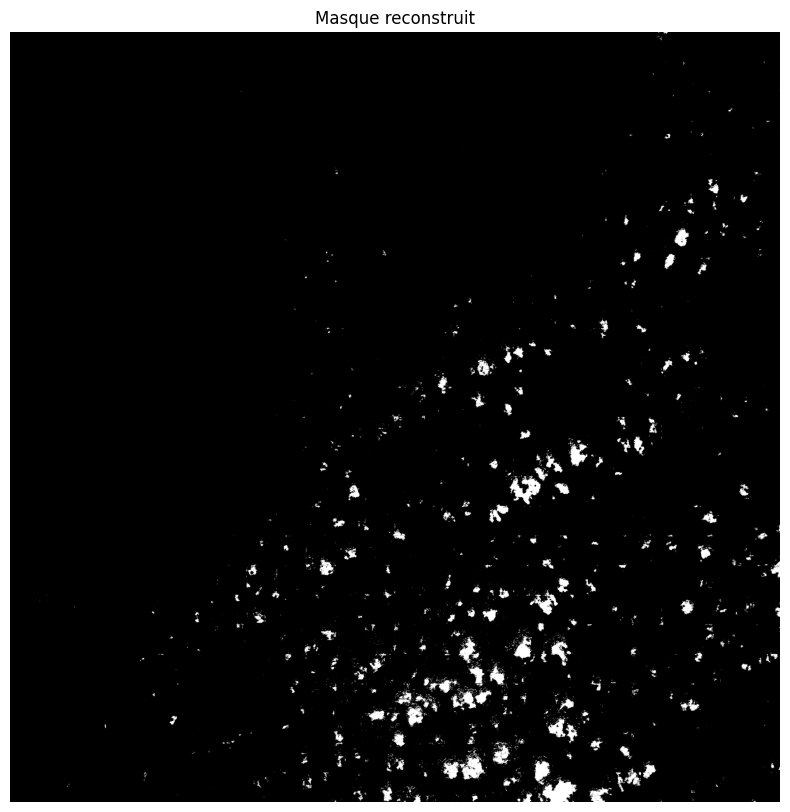

In [75]:
csv_path = Path("dataset.csv")
dataset = SentinelTilingDataset(csv_path)

device = "cuda" if torch.cuda.is_available() else "cpu"

masks = run_inference(model, dataset, image_shape=(10180, 10180), device=device, image_index=2)

for idx, mask in masks.items():
    show_prediction(mask.numpy(), threshold=0.5)
    save_mask_as_png_pil(mask.numpy(), f"results/mask_image_{idx:03d}.png", threshold=0.5)


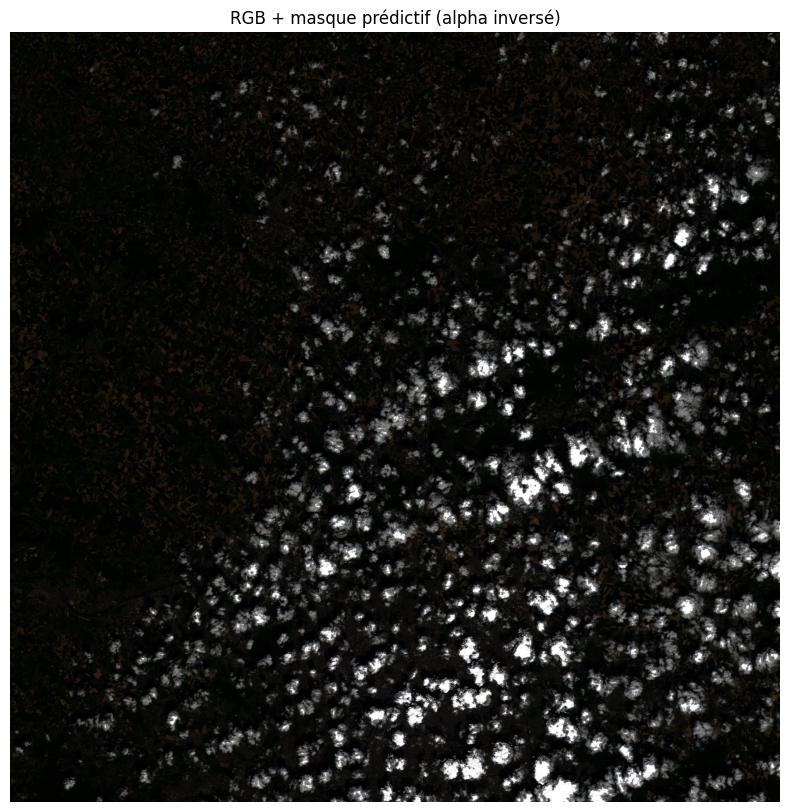

In [80]:
def create_rgba_from_dataset(dataset, mask: np.ndarray, image_idx: int = 2) -> np.ndarray:
    """
    Crée une image RGBA en utilisant les chemins RGB depuis dataset.data,
    et le masque de prédiction fourni.
    """
    row = dataset.data.iloc[image_idx]
    rgb_paths = {band: row[band] for band in ["red", "green", "blue"]}

    def normalize_stretch(img, min_percent=2, max_percent=98):
        min_val = np.percentile(img, min_percent)
        max_val = np.percentile(img, max_percent)
        return np.clip((img - min_val) / (max_val - min_val), 0, 1)

    channels = []
    for band in ["red", "green", "blue"]:
        with rasterio.open(rgb_paths[band]) as src:
            img = src.read(1).astype(np.float32) / 65535.0
            img = normalize_stretch(img)  # Normalisation pour étirer les valeurs
            channels.append(img)

    rgb = np.stack(channels, axis=-1)  # (H, W, 3)
    H_mask, W_mask = mask.shape
    rgb = rgb[:H_mask, :W_mask, :]  # crop pour correspondre au masque

    alpha = 1 - mask  # inverse du masque : +transparent si prédiction forte
    alpha = np.clip(alpha, 0.0, 1.0)

    rgba = np.concatenate([rgb, alpha[..., None]], axis=-1)  # (H, W, 4)
    return rgba


def show_rgba_mask(rgb: np.ndarray, alpha: np.ndarray, threshold: float = 0.5):
    """
    Affiche une image RGB avec alpha inversé comme masque en superposition.
    Les zones prédictives (alpha faible) seront masquées.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)

    # On affiche le masque inverse : là où alpha est faible → masque blanc
    mask = (alpha < threshold).astype(float)
    plt.imshow(mask, cmap="gray", alpha=0.5)  # superposition semi-transparente

    plt.title("RGB + masque prédictif (alpha inversé)")
    plt.axis("off")
    plt.show()


# Génération RGBA
rgba = create_rgba_from_dataset(dataset, mask, image_idx=2)
rgb = rgba[..., :3]
alpha = rgba[..., 3]

show_rgba_mask(rgb, alpha, threshold=0.5)


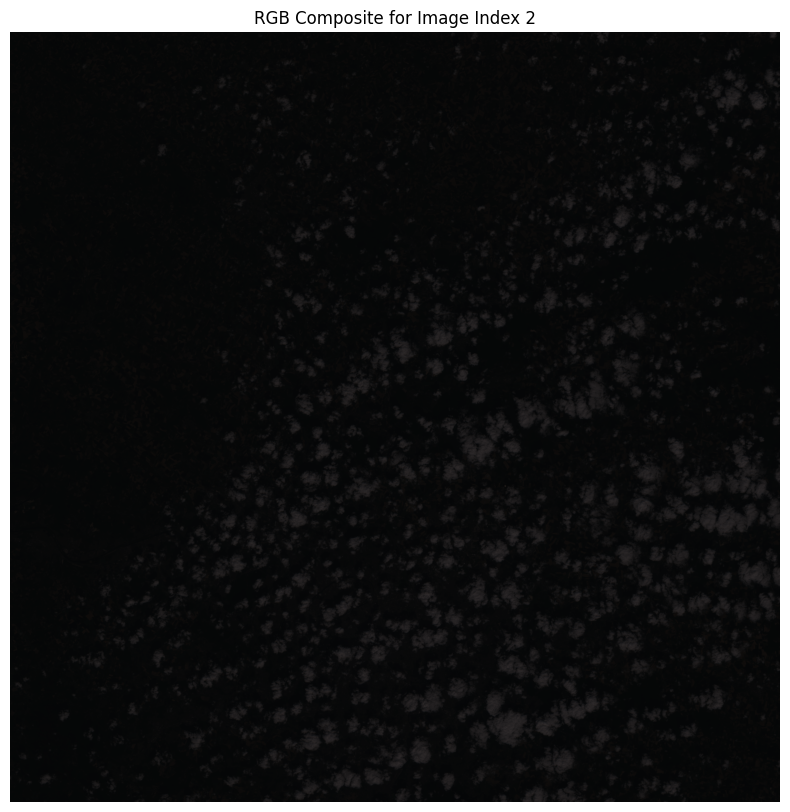

In [ ]:
# show each line of the dataset as RGB composite


def show_rgb_composite(dataset: SentinelTilingDataset, image_idx: int = 0):
    """
    Affiche une image RGB composite à partir des bandes RGB du dataset.
    """
    row = dataset.data.iloc[image_idx]
    rgb_paths = {band: row[band] for band in ["red", "green", "blue"]}

    channels = []
    for band in ["red", "green", "blue"]:
        with rasterio.open(rgb_paths[band]) as src:
            img = src.read(1).astype(np.float32) / 65535.0
            channels.append(img)

    rgb = np.stack(channels, axis=-1)  # (H, W, 3)

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title(f"RGB Composite for Image Index {image_idx}")
    plt.axis("off")
    plt.show()


# Afficher la première ligne du dataset
show_rgb_composite(dataset, image_idx=2)

In [ ]:
def show_rgb_with_gt_mask(dataset: SentinelTilingDataset, masks) -> None:
    file_entry = dataset.data.iloc[dataset.data.index[0]]  # Get the first entry
    channels = []
    for color in ["red", "green", "blue"]:
        img = rasterio.open(file_entry[color]).read(1)  # Read the image as a 2D array
        arr = np.array(img, dtype=np.uint16)

        channels.append(arr)

    h, w = channels[0].shape
    if not all(c.shape == (h, w) for c in channels):
        raise ValueError("RGB channels are not of the same size.")

    rgb16 = np.stack(channels, axis=-1)  # shape (H, W, 3), dtype uint16

    # gt becomes the alpha but we must invert it because the mask is white on clouds
    gt = np.array(masks[0], dtype=np.uint16)  # Assuming masks is a dict with image_idx as key
    if gt.shape != (h, w):
        raise ValueError("gt mask size does not match RGB images.")

    # Binariser l'alpha si nécessaire
    if gt.max() > 1:
        alpha = (gt > 0).astype(np.uint16) * 65535
    else:
        alpha = (gt > 0).astype(np.uint16) * 65535

    alpha = 65535 - alpha  # Invert alpha mask to show clouds as transparent

    # Normalized RGB and alpha channels for visualization
    rgb_visu = ((rgb16 - rgb16.min()) / (rgb16.max() - rgb16.min()) * 255).astype(np.uint8)
    alpha_visu = (alpha / 65535 * 255).astype(np.uint8)
    rgba_visu = np.dstack((rgb_visu, alpha_visu))

    plt.figure(figsize=(5, 5))
    plt.imshow(rgba_visu)
    plt.title("RGBA Composite (RGB + GT Mask)")
    plt.axis("off")
    plt.show()


show_rgb_with_gt_mask(dataset, masks)